# 4. Implementation
Below is Python experiments for each method described in the report. 



# 4.1 Reinforcement Learning for Multi-Flow Coordination

## Overview
In this section, we explore a variation of the Reinforcement Learning (RL) approach for TCP congestion control, where an RL "agent" dynamically updates the policy parameters 𝛼1 & 𝛽1, 𝛼2 & 𝛽2 for each flow at every iteration. The agent attempts small random adjustments to these parameters, with the goal of converging towards a stable operating point while avoiding network congestion.
The RL "agent" follows a heuristic-driven approach where each iteration acts as an RL "step," applying incremental changes to 𝛼 & 𝛽. A reward function is used to evaluate performance, primarily based on how effectively the queue capacity is utilized without causing overflows.The primary objective is to demonstrate how reinforcement learning-inspired methods can be integrated with TCP congestion control to achieve both fairness and efficiency in multi-flow environments. By comparing both versions, we analyze the trade-offs between exploration and convergence stability.

### Implemented Versions
- **Version 1: Constant Gamma Exploration**  
  This version maintains a relatively steady level of random exploration throughout the simulation, which can result in a more dynamic path to convergence. The final convergent point may vary, and the graph may exhibit significant "bouncing" before settling.

- **Version 2: Decaying Gamma for Gradual Convergence**  
  In this version, the exploration rate (`gamma`) decays over time, leading to smaller random steps as the iterations progress. This strategy encourages a more stable and gradual approach to the optimal (25,25) point, showing how the agent learns to reduce aggressive changes as it nears the ideal solution.





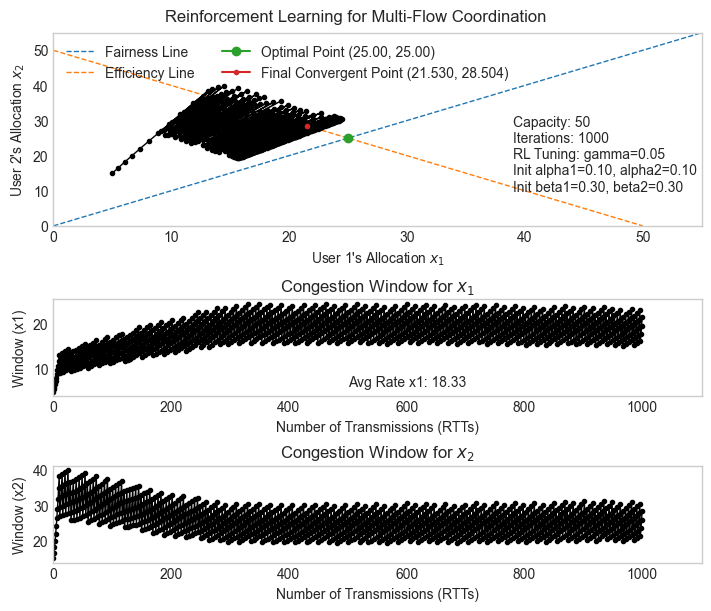

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

def rl_plot(C:int,
            x1:float,
            x2:float,
            alpha1:float,
            alpha2:float,
            beta1:float=0.5,
            beta2:float=0.5,
            gamma:float=0.05,
            output:str='output_rl.svg',
            title:str='RL Multi-Flow Coordination'):
    """
    Plot a graph for a Reinforcement Learning approach
    that coordinates two flows' alpha and beta.

    Args:
        C (int): Max capacity. If x1 + x2 > C, we consider it "congested."
        x1 (float): Initial 'window' (or rate) for flow 1
        x2 (float): Initial 'window' (or rate) for flow 2
        alpha1 (float): Initial multiplicative-increase factor for flow 1
        alpha2 (float): Initial multiplicative-increase factor for flow 2
        beta1 (float): Initial multiplicative-decrease factor for flow 1
        beta2 (float): Initial multiplicative-decrease factor for flow 2
        gamma (float): "Learning rate" for random parameter updates
        output (str): Output filename in SVG format
        title (str): Chart title
    """
    # Set up iteration limits and initial values
    iterations = 0
    max_iters = 1000

    # Track each iteration's x1, x2
    x1_values = [x1]
    x2_values = [x2]

    # Compute "optimal point" for reference (like the fairness/efficiency lines)
    optimal_x = (C - 0) / (1 - -1)
    optimal_y = C - optimal_x

    # We also keep track of alpha/beta changes over time
    alpha1_init, alpha2_init = alpha1, alpha2
    beta1_init,  beta2_init  = beta1,  beta2

    while iterations < max_iters:
        iterations += 1

        # Decaying gamma each iteration so the random changes become smaller over time
        decay_factor = 0.995 ** iterations
        current_gamma = gamma * decay_factor

        # -- RL "agent" step: tweak alpha/beta randomly --
        alpha1 += current_gamma * random.uniform(-0.02, 0.02)
        alpha2 += current_gamma * random.uniform(-0.02, 0.02)
        beta1  += current_gamma * random.uniform(-0.02, 0.02)
        beta2  += current_gamma * random.uniform(-0.02, 0.02)

        # Keep them in some reasonable range, Keep alpha in [0.01, ...], beta in [0.01, 0.99]
        alpha1 = max(alpha1, 0.01)
        alpha2 = max(alpha2, 0.01)
        beta1  = min(max(beta1, 0.01), 0.99)
        beta2  = min(max(beta2, 0.01), 0.99)

        # -- Congestion logic --
        total = x1 + x2
        if total <= C:
            x1 = x1 + alpha1 
            x2 = x2 + alpha2 
        else:
            x1 = x1 * (1 - beta1)
            x2 = x2 * (1 - beta2)

        x1_values.append(x1)
        x2_values.append(x2)

        # Simple condition to break if close to "optimal" intersection
        if (abs(x1 - optimal_x) < 0.01) and (abs(x2 - optimal_y) < 0.01):
            break

    # Calculate average sending rate for each flow
    sr_x1 = np.mean(x1_values)
    sr_x2 = np.mean(x2_values)

    # -- Plotting --
    fig = plt.figure(figsize=(7, 6), layout="constrained")
    plt.style.use("seaborn-v0_8-whitegrid")

    # Subplots
    plot1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=4)
    plot2 = plt.subplot2grid((8, 2), (4, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((8, 2), (6, 0), colspan=2, rowspan=2)

    # Fairness line: x1 = x2
    fairness_line_x_values = np.linspace(0, C * 1.1, 100)
    plot1.plot(fairness_line_x_values, fairness_line_x_values,label='Fairness Line', linestyle='dashed', linewidth=1)

    # Efficiency line: x1 + x2 = C
    efficiency_line_x_values = np.linspace(0, C, 100)
    efficiency_line_y_values = C - efficiency_line_x_values
    plot1.plot(efficiency_line_x_values, efficiency_line_y_values,
               label='Efficiency Line', linestyle='dashed', linewidth=1)

    # Optimal point
    plot1.plot(optimal_x, optimal_y, marker='o',
               label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # RL trajectory
    plot1.plot(x1_values, x2_values, marker='.', color='black', linewidth=1)

    # Final point
    plot1.plot(x1_values[-1], x2_values[-1], marker='.',
               label=f'Final Convergent Point ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    plot1.set_xlabel("User 1's Allocation $x_1$")
    plot1.set_ylabel("User 2's Allocation $x_2$")
    plot1.set_xlim(0, C * 1.1)
    plot1.set_ylim(0, C * 1.1)
    plot1.grid(False)
    plot1.legend(loc='upper left', ncol=2)
    plot1.annotate(f"Capacity: {C}\nIterations: {iterations}\n"
                   f"RL Tuning: gamma={gamma:.2f}\n"
                   f"Init alpha1={alpha1:.2f}, alpha2={alpha2:.2f}\n"
                   f"Init beta1={beta1:.2f}, beta2={beta2:.2f}",
                   xy=(0.78*C, 0.2*C))

    # RTT axis (just iteration counts)
    rtt_values = np.arange(len(x1_values))

    # Subplot for x1
    plot2.plot(rtt_values, x1_values, marker='.', color='black', linewidth=1)
    plot2.set_xlabel("Number of Transmissions (RTTs)")
    plot2.set_ylabel("Window (x1)")
    plot2.set_title("Congestion Window for $x_1$")
    plot2.set_xlim(0, len(x1_values)*1.1)
    plot2.annotate(f"Avg Rate x1: {sr_x1:.2f}", xy=(len(x1_values)/2, C/8))
    plot2.grid(False)

    # Subplot for x2
    plot3.plot(rtt_values, x2_values, marker='.', color='black', linewidth=1)
    plot3.set_xlabel("Number of Transmissions (RTTs)")
    plot3.set_ylabel("Window (x2)")
    plot3.set_title("Congestion Window for $x_2$")
    plot3.set_xlim(0, len(x2_values)*1.1)
    plot3.annotate(f"Avg Rate x2: {sr_x2:.2f}", xy=(len(x2_values)/2, C/8))
    plot3.grid(False)

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()


# Example usage:
if __name__ == "__main__":

    rl_plot(C=50,
            x1=5.0,
            x2=15.0,
            alpha1=0.1,
            alpha2=0.1,
            beta1=0.3,
            beta2=0.3,
            gamma=0.05,
            output=f"rl_ver1.svg",
            title="Reinforcement Learning for Multi-Flow Coordination"
           )


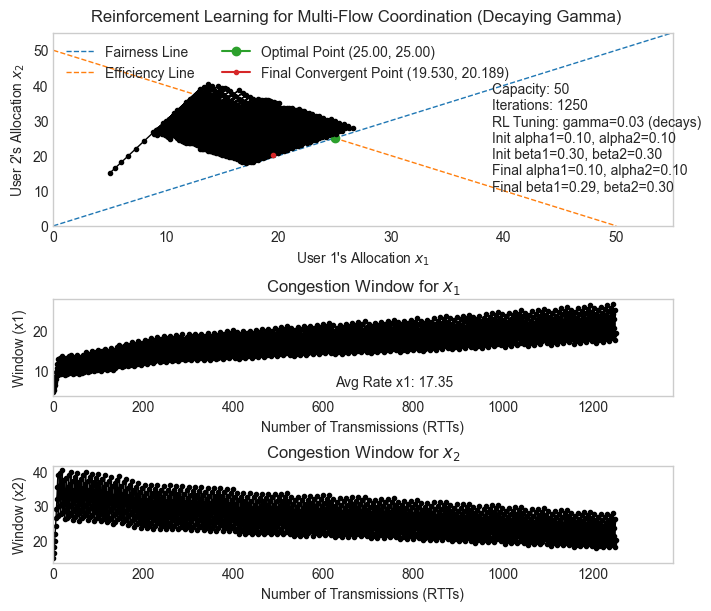

In [48]:
##Version 2: Decaying Gamma for Exploration
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

def rl_plot(C:int,
            x1:float,
            x2:float,
            alpha1:float,
            alpha2:float,
            beta1:float=0.5,
            beta2:float=0.5,
            gamma:float=0.05,
            output:str='output_rl.svg',
            title:str='RL Multi-Flow Coordination'):
    """
    Plot a graph for a Reinforcement Learning approach
    that coordinates two flows' alpha and beta.

    This version includes a decaying gamma to allow
    random exploration to diminish over time, helping
    the flows converge near optimal point (i.e. (25,25) for capacity=50)
    without forcing them to exactly stop there.

    Args:
        C (int): Max capacity. If (x1 + x2) > C => we consider it "congested."
        x1 (float): Initial 'window' (or rate) for flow 1
        x2 (float): Initial 'window' (or rate) for flow 2
        alpha1 (float): Initial multiplicative-increase factor for flow 1
        alpha2 (float): Initial multiplicative-increase factor for flow 2
        beta1 (float): Initial multiplicative-decrease factor for flow 1
        beta2 (float): Initial multiplicative-decrease factor for flow 2
        gamma (float): Initial "learning rate" for random parameter updates
        output (str): Output filename in SVG format
        title (str): Chart title
    """

    max_iters = 1250
    iterations = 0

    # Keep track of x1, x2 for plotting
    x1_values = [x1]
    x2_values = [x2]

    # For reference, compute the "optimal point" (25,25) if C=50
    optimal_x = (C - 0) / (1 - -1)  # 25 if C=50
    optimal_y = C-optimal_x  # also 25 if C=50

    # Remember initial alpha/beta values for annotation
    init_alpha1, init_alpha2 = alpha1, alpha2
    init_beta1, init_beta2   = beta1, beta2

    while iterations < max_iters:
        iterations += 1

        # Decay gamma over time so random steps shrink
        decay_factor = 0.995 ** iterations
        current_gamma = gamma * decay_factor

        # Randomly tweak alpha/beta
        alpha1 += current_gamma * random.uniform(-0.02, 0.02)
        alpha2 += current_gamma * random.uniform(-0.02, 0.02)
        beta1  += current_gamma * random.uniform(-0.02, 0.02)
        beta2  += current_gamma * random.uniform(-0.02, 0.02)

        # Ensure alpha/beta remain in valid ranges
        alpha1 = max(alpha1, 0.01)
        alpha2 = max(alpha2, 0.01)
        beta1  = min(max(beta1, 0.01), 0.99)
        beta2  = min(max(beta2, 0.01), 0.99)

        # Congestion logic
        total = x1 + x2
        if total <= C:
            x1 = x1 + alpha1
            x2 = x2 + alpha2
        else:
            x1 = x1 * (1 - beta1)
            x2 = x2 * (1 - beta2)

        x1_values.append(x1)
        x2_values.append(x2)

    # Compute average sending rate for each flow
    sr_x1 = np.mean(x1_values)
    sr_x2 = np.mean(x2_values)

    # Plotting
    fig = plt.figure(figsize=(7, 6), layout="constrained")
    plt.style.use("seaborn-v0_8-whitegrid")

    # Subplots
    plot1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=4)
    plot2 = plt.subplot2grid((8, 2), (4, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((8, 2), (6, 0), colspan=2, rowspan=2)

    # Plot fairness line x1=x2
    fairness_line_x_values = np.linspace(0, C * 1.1, 100)
    plot1.plot(fairness_line_x_values, fairness_line_x_values,
               label='Fairness Line', linestyle='dashed', linewidth=1)

    # Plot efficiency line x1 + x2 = C
    efficiency_line_x_values = np.linspace(0, C, 100)
    efficiency_line_y_values = C - efficiency_line_x_values
    plot1.plot(efficiency_line_x_values, efficiency_line_y_values,
               label='Efficiency Line', linestyle='dashed', linewidth=1)

    # Mark the optimal point
    plot1.plot(optimal_x, optimal_y, marker='o',
               label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # RL trajectory
    plot1.plot(x1_values, x2_values, marker='.', color='black', linewidth=1)

    # Final point
    final_str = f"({x1_values[-1]:.3f}, {x2_values[-1]:.3f})"
    plot1.plot(x1_values[-1], x2_values[-1], marker='.',
               label=f'Final Convergent Point {final_str}')

    plot1.set_xlabel("User 1's Allocation $x_1$")
    plot1.set_ylabel("User 2's Allocation $x_2$")
    plot1.set_xlim(0, C * 1.1)
    plot1.set_ylim(0, C * 1.1)
    plot1.grid(False)
    plot1.legend(loc='upper left', ncol=2)

    annotation_txt = (
        f"Capacity: {C}\n"
        f"Iterations: {iterations}\n"
        f"RL Tuning: gamma={gamma:.2f} (decays)\n"
        f"Init alpha1={init_alpha1:.2f}, alpha2={init_alpha2:.2f}\n"
        f"Init beta1={init_beta1:.2f}, beta2={init_beta2:.2f}\n"
        f"Final alpha1={alpha1:.2f}, alpha2={alpha2:.2f}\n"
        f"Final beta1={beta1:.2f}, beta2={beta2:.2f}"
    )
    plot1.annotate(annotation_txt, xy=(0.78*C, 0.2*C))

    # Time axis for subplots
    rtt_values = np.arange(len(x1_values))

    # Subplot for x1
    plot2.plot(rtt_values, x1_values, marker='.', color='black', linewidth=1)
    plot2.set_xlabel("Number of Transmissions (RTTs)")
    plot2.set_ylabel("Window (x1)")
    plot2.set_title("Congestion Window for $x_1$")
    plot2.set_xlim(0, len(x1_values)*1.1)
    plot2.annotate(f"Avg Rate x1: {sr_x1:.2f}", xy=(len(x1_values)/2, C/8))
    plot2.grid(False)

    # Subplot for x2
    plot3.plot(rtt_values, x2_values, marker='.', color='black', linewidth=1)
    plot3.set_xlabel("Number of Transmissions (RTTs)")
    plot3.set_ylabel("Window (x2)")
    plot3.set_title("Congestion Window for $x_2$")
    plot3.set_xlim(0, len(x2_values)*1.1)
    plot3.annotate(f"Avg Rate x2: {sr_x2:.2f}", xy=(len(x2_values)/2, C/8))
    plot3.grid(False)

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()


# Example usage:
if __name__ == "__main__":

    rl_plot(
        C=50,
        x1=5.0,
        x2=15.0,
        alpha1=0.1,
        alpha2=0.1,
        beta1=0.3,
        beta2=0.3,
        gamma=0.03,
        output=f"rl_ver2.svg",
        title="Reinforcement Learning for Multi-Flow Coordination (Decaying Gamma)"
    )


### **Reinforcement Learning for Multi-Flow Coordination**  
As shown in Results 1 and 2, the reinforcement learning (RL) agent starts with moderate congestion window settings and introduces random adjustments to the α and β parameters at each iteration. Both the constant gamma and decaying gamma versions exhibit initial exploratory fluctuations, with the flows oscillating before gradually settling toward an operating point near the fairness line and below the efficiency boundary. Although neither version precisely hits (25,25), both effectively avoid queue overflows by incrementally tuning their parameters, demonstrating how RL can balance capacity utilization and congestion avoidance. The decaying gamma approach produces somewhat gentler long-term behavior, while the constant gamma maintains a higher level of random exploration throughout the simulation.  

---

# 4.2 Hybrid Queue-Based + Window-Based Control

## Overview
In this section, we introduce a Hybrid Queue-Based + Window-Based Control approach for TCP congestion management. This method utilizes a predefined threshold to determine network congestion status. When the sum of the congestion windows (`𝑥1+𝑥2`) is below the threshold, the algorithm employs an **Additive Increase** strategy, allowing the windows to grow incrementally. Conversely, if the combined window size exceeds the threshold, a **Multiplicative Decrease** is triggered to quickly reduce congestion. (i.e. We we define a threshold < 𝐶. If the sum of the flows’ cwnds is below it, we assume “no congestion” → additive increase. Otherwise → multiplicative decrease.)

This approach offers a simplified alternative to Explicit Congestion Notification (ECN) mechanisms found in more advanced research. By using the threshold as a binary congestion signal, this method demonstrates how fundamental principles of congestion control can be implemented from scratch while achieving a balance between fairness and efficiency. The goal is to illustrate how a hybrid control model can adaptively manage flow rates in a multi-flow environment, showcasing both the benefits and limitations of a threshold-driven approach.


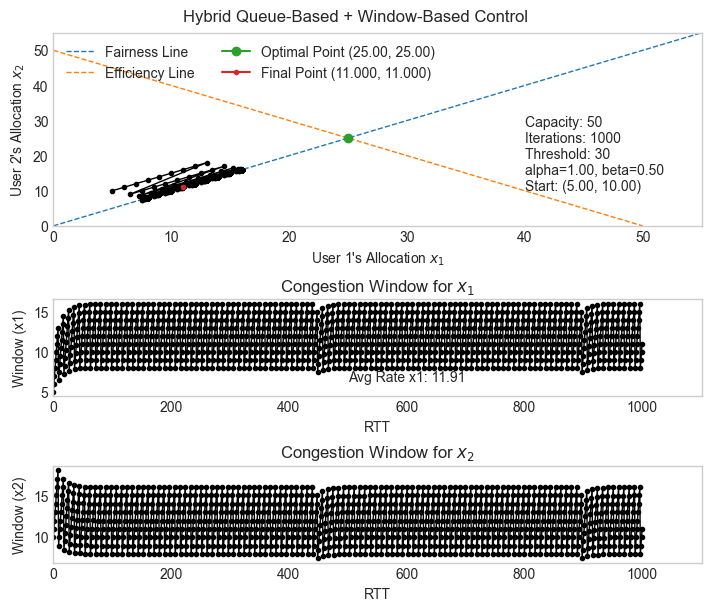

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

def hybrid_queue_plot(C:int,
                      x1:float,
                      x2:float,
                      alpha:float,
                      beta:float,
                      threshold:float,
                      output:str='output_hybrid.svg',
                      title:str='Hybrid Queue-Based + Window-Based Control'):
    """
    Plot a graph for a hybrid queue-based approach with two flows.
    If (x1 + x2) < threshold => additive increase;
    else => multiplicative decrease.

    Args:
        C (int): Capacity of the link
        x1, x2 (float): Initial windows for flow 1, flow 2
        alpha (float): Additive increase amount
        beta (float): Fraction for multiplicative decrease
        threshold (float): Congestion threshold
        output (str): Name of output SVG file
        title (str): Chart title
    """

    max_iters = 1000
    iterations = 0

    # Track values over iterations
    x1_values = [x1]
    x2_values = [x2]

    # Optimal point for reference
    optimal_x = (C - 0) / (1 - -1)
    optimal_y = C - optimal_x

    while iterations < max_iters:
        iterations += 1
        
        # Decide whether to do additive or multiplicative update
        total = x1 + x2
        if total < threshold:
            # Additive increase
            x1 += alpha
            x2 += alpha
        else:
            # Multiplicative decrease
            x1 = x1 * (1 - beta)
            x2 = x2 * (1 - beta)

        x1_values.append(x1)
        x2_values.append(x2)

        # Break if we are close enough to the optimal point
        if abs(x1 - optimal_x) < 0.01 and abs(x2 - optimal_y) < 0.01:
            break

    # Calculate average sending rate
    sr_x1 = np.mean(x1_values)
    sr_x2 = np.mean(x2_values)

    # Plot
    fig = plt.figure(figsize=(7, 6), layout="constrained")
    plt.style.use("seaborn-v0_8-whitegrid")

    plot1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=4)
    plot2 = plt.subplot2grid((8, 2), (4, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((8, 2), (6, 0), colspan=2, rowspan=2)

    fairness_line_x_values = np.linspace(0, C*1.1, 100)
    plot1.plot(fairness_line_x_values, fairness_line_x_values,
               label='Fairness Line', linestyle='dashed', linewidth=1)

    efficiency_line_x_values = np.linspace(0, C, 100)
    efficiency_line_y_values = C - efficiency_line_x_values
    plot1.plot(efficiency_line_x_values, efficiency_line_y_values,
               label='Efficiency Line', linestyle='dashed', linewidth=1)

    plot1.plot(optimal_x, optimal_y, marker='o',
               label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    plot1.plot(x1_values, x2_values, marker='.', color='black', linewidth=1)
    plot1.plot(x1_values[-1], x2_values[-1], marker='.',
               label=f'Final Point ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    plot1.set_xlabel("User 1's Allocation $x_1$")
    plot1.set_ylabel("User 2's Allocation $x_2$")
    plot1.set_xlim(0, C*1.1)
    plot1.set_ylim(0, C*1.1)
    plot1.grid(False)
    plot1.legend(loc='upper left', ncol=2)
    plot1.annotate(f"Capacity: {C}\nIterations: {iterations}\n"
                   f"Threshold: {threshold}\nalpha={alpha:.2f}, beta={beta:.2f}\n"
                   f"Start: ({x1_values[0]:.2f}, {x2_values[0]:.2f})",
                   xy=(0.8*C, 0.2*C))

    rtt_values = np.arange(len(x1_values))
    plot2.plot(rtt_values, x1_values, marker='.', color='black', linewidth=1)
    plot2.set_xlabel("RTT")
    plot2.set_ylabel("Window (x1)")
    plot2.set_title("Congestion Window for $x_1$")
    plot2.set_xlim(0, len(x1_values)*1.1)
    plot2.annotate(f"Avg Rate x1: {sr_x1:.2f}", xy=(len(x1_values)/2, C/8))
    plot2.grid(False)

    plot3.plot(rtt_values, x2_values, marker='.', color='black', linewidth=1)
    plot3.set_xlabel("RTT")
    plot3.set_ylabel("Window (x2)")
    plot3.set_title("Congestion Window for $x_2$")
    plot3.set_xlim(0, len(x2_values)*1.1)
    plot3.annotate(f"Avg Rate x2: {sr_x2:.2f}", xy=(len(x2_values)/2, C/8))
    plot3.grid(False)

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()


# Example usage:
if __name__ == "__main__":
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")

    hybrid_queue_plot(C=50,
                      x1=5.0,
                      x2=10.0,
                      alpha=1.0,
                      beta=0.5,
                      threshold=30,
                      output=f"hybrid_{formatted_time}.svg",
                      title="Hybrid Queue-Based + Window-Based Control"
                     )


### **Hybrid Queue-Based + Window-Based Control**  
In result 3, we see that this threshold-based algorithm triggers additive increases when the combined congestion windows stay below the specified threshold and applies multiplicative decreases when they exceed it. The resulting sawtooth-like pattern maintains a moderate congestion window size, converging around (11,11) and thus avoiding persistent overshoot of the link capacity. While the flows do not grow to very large windows, they remain stable once they reach their threshold-limited equilibrium, thereby confirming that even a simple threshold mechanism can regulate congestion effectively without advanced ECN signals.  

---

# 4.3 Simplified HPCC-Inspired (Rate-Based) Approach

## Overview
In this section, we present a simplified approximation of High Precision Congestion Control (HPCC). Rather than using multi-hop in-network telemetry, we maintain a single queue variable to 𝐶. If the combined rate exceeds 𝐶, the queue grows; otherwise, it partially drains. Both flows then adjust their sending rates toward a target queue size 𝑄∗. This approach models how HPCC-like mechanisms can keep queues shallow while quickly responding to changes in offered load.

{i.e. Here we treat 𝑥1 & 𝑥2 as sending rates (in segments/RTT or similar). We maintain a queue variable to track congestion. Each iteration:

- If (𝑥1+𝑥2) > capacity 𝐶, the queue grows.
- Otherwise, the queue partially drains.
- We adjust each rate to push the queue toward a target 𝑄∗.}

### Implemented Versions
- **Version 1: Basic HPCC Rate Control**  
  This version (`hpcc_rate_plot`) focuses solely on maintaining the queue near 𝑄∗. Both flows move their rates up or down based on how much the actual queue deviates from 𝑄∗. Over many iterations, the system converges to a stable point, although it may not strictly enforce fairness between flows.

- **Version 2: HPCC Rate Control + Fairness Nudging**  
  This version (`hpcc_fair_rate_plot`) adds a small “fairness” term. In addition to pushing the queue toward 𝑄∗, it gently nudges the two flows’ rates closer together if one rate grows substantially higher than the other. This hybrid approach preserves the primary HPCC objective of maintaining a stable queue while promoting balanced rate allocations, potentially converging near the (25,25) fairness point when C = 50.


In [ ]:
# def hpcc_rate_based(C=100, N=3, RTTs=200, Q_star=10, gain=0.05):
#     """
#     Simplified HPCC-based approach using a single queue model
#     and rate-based control rather than cwnd.
#     C: link capacity
#     N: number of flows
#     Q_star: desired queue size target
#     gain: controls how aggressively rates are adjusted
#     """
#     rates = np.ones(N) * 5.0  # initial sending rates
#     queue = 0.0
#     history = []

#     for t in range(RTTs):
#         total_send = np.sum(rates)

#         # Update queue
#         if total_send > C:
#             queue += (total_send - C)
#         else:
#             reduction = min(queue, C - total_send)
#             queue -= reduction

#         # HPCC-inspired rate adjustment:
#         # Each flow sees queue and tries to keep queue ~ Q_star
#         for i in range(N):
#             delta = gain * (Q_star - queue)
#             rates[i] = max(rates[i] + delta, 0.0)

#         history.append(rates.copy())

#     return np.array(history)


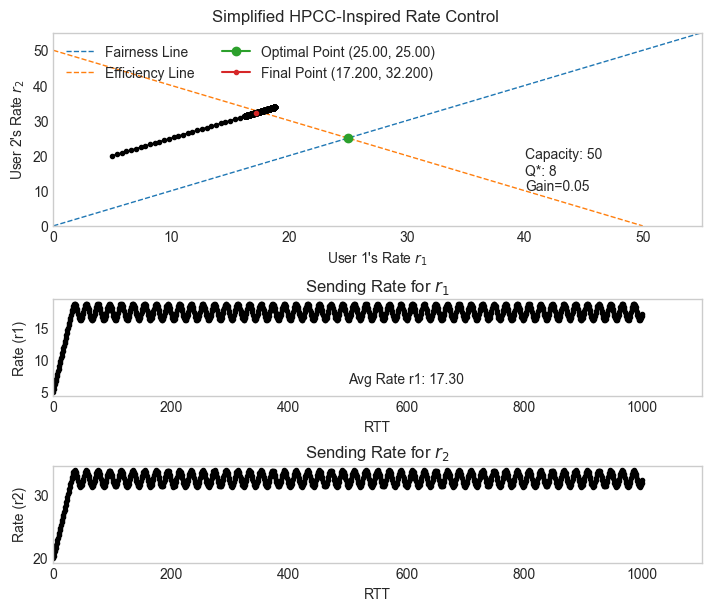

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def hpcc_rate_plot(C:int,
                   r1:float,
                   r2:float,
                   Q_star:float=10.0,
                   gain:float=0.05,
                   max_iters:int=1000,
                   output:str='output_hpcc.svg',
                   title:str='HPCC-Inspired Rate Control'):
    """
    A simplified HPCC-like approach where r1, r2 are sending rates
    for two flows. We keep track of a single 'queue' variable,
    and adjust rates each iteration to push queue toward Q_star.

    Args:
        C (int): Link capacity (units/RTT)
        r1, r2 (float): Initial sending rates for two flows
        Q_star (float): Desired queue target
        gain (float): Adjusts how aggressively we update rates
        max_iters (int): Max RTT iterations
        output (str): SVG filename
        title (str): Chart title
    """

    # Initialize
    queue = 0.0
    rates1 = [r1]
    rates2 = [r2]

    # For plotting the "optimal line" on x1 vs x2 chart,
    # we keep the same logic: fairness = x1 = x2, efficiency = x1 + x2 = C
    optimal_x = (C - 0) / (1 - -1)
    optimal_y = C-optimal_x 

    for step in range(max_iters):
        total_rate = r1 + r2

        # Update queue
        if total_rate > C:
            queue += (total_rate - C)
        else:
            drain = min(queue, (C - total_rate))
            queue -= drain

        # Rate adjustment: push queue toward Q_star
        delta1 = gain * (Q_star - queue)
        delta2 = gain * (Q_star - queue)

        r1 = max(r1 + delta1, 0.0)
        r2 = max(r2 + delta2, 0.0)

        rates1.append(r1)
        rates2.append(r2)

        # Stopping condition if near "optimal" intersection
        if (abs(r1 - optimal_x) < 0.01) and (abs(r2 - optimal_y) < 0.01):
            break

    sr_x1 = np.mean(rates1)
    sr_x2 = np.mean(rates2)

    # Plot
    fig = plt.figure(figsize=(7, 6), layout="constrained")
    plt.style.use("seaborn-v0_8-whitegrid")

    plot1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=4)
    plot2 = plt.subplot2grid((8, 2), (4, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((8, 2), (6, 0), colspan=2, rowspan=2)

    # Fairness line
    fairness_line_x_values = np.linspace(0, C*1.1, 100)
    plot1.plot(fairness_line_x_values, fairness_line_x_values,
               label='Fairness Line', linestyle='dashed', linewidth=1)

    # Efficiency line
    efficiency_line_x_values = np.linspace(0, C, 100)
    efficiency_line_y_values = C - efficiency_line_x_values
    plot1.plot(efficiency_line_x_values, efficiency_line_y_values,
               label='Efficiency Line', linestyle='dashed', linewidth=1)

    # Optimal point
    plot1.plot(optimal_x, optimal_y, marker='o',
               label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # Trajectory
    plot1.plot(rates1, rates2, marker='.', color='black', linewidth=1)
    plot1.plot(rates1[-1], rates2[-1], marker='.',
               label=f'Final Point ({rates1[-1]:.3f}, {rates2[-1]:.3f})')

    plot1.set_xlabel("User 1's Rate $r_1$")
    plot1.set_ylabel("User 2's Rate $r_2$")
    plot1.set_xlim(0, C*1.1)
    plot1.set_ylim(0, C*1.1)
    plot1.grid(False)
    plot1.legend(loc='upper left', ncol=2)
    plot1.annotate(f"Capacity: {C}\nQ*: {Q_star}\nGain={gain}",
                   xy=(0.8*C, 0.2*C))

    # RTT iteration axis
    rtt_values = np.arange(len(rates1))
    plot2.plot(rtt_values, rates1, marker='.', color='black', linewidth=1)
    plot2.set_xlabel("RTT")
    plot2.set_ylabel("Rate (r1)")
    plot2.set_title("Sending Rate for $r_1$")
    plot2.set_xlim(0, len(rates1)*1.1)
    plot2.annotate(f"Avg Rate r1: {sr_x1:.2f}", xy=(len(rates1)/2, C/8))
    plot2.grid(False)

    plot3.plot(rtt_values, rates2, marker='.', color='black', linewidth=1)
    plot3.set_xlabel("RTT")
    plot3.set_ylabel("Rate (r2)")
    plot3.set_title("Sending Rate for $r_2$")
    plot3.set_xlim(0, len(rates2)*1.1)
    plot3.annotate(f"Avg Rate r2: {sr_x2:.2f}", xy=(len(rates2)/2, C/8))
    plot3.grid(False)

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()

# Example usage:
if __name__ == "__main__":

    hpcc_rate_plot(C=50,
                   r1=5.0,
                   r2=20.0,
                   Q_star=8,
                   gain=0.05,
                   output=f"hpcc_ver1.svg",
                   title="Simplified HPCC-Inspired Rate Control"
                  )


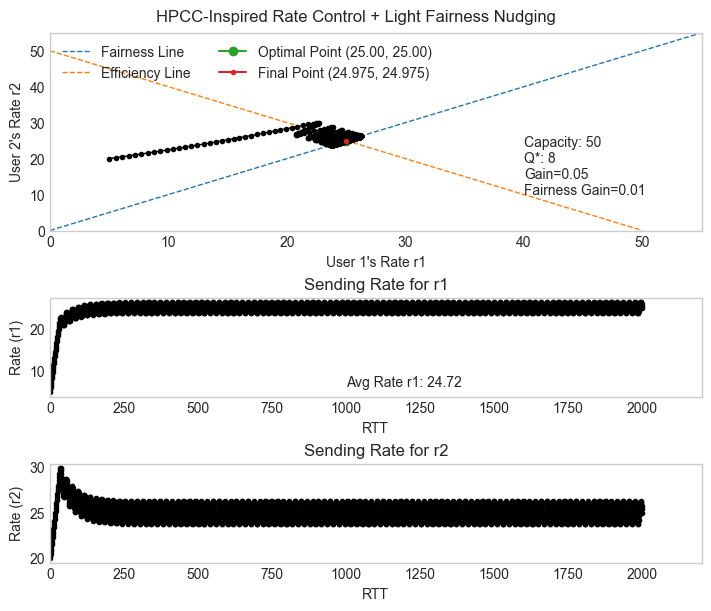

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def hpcc_fair_rate_plot(C:int,
                        r1:float,
                        r2:float,
                        Q_star:float=10.0,
                        gain:float=0.05,
                        fairness_gain:float=0.01,
                        max_iters:int=2000,
                        output:str='output_hpcc_fair.svg',
                        title:str='HPCC-Inspired Rate Control + Fairness'):
    """
    A modified HPCC-like approach that adds a small 'fairness' term
    to push the two flow rates closer together over time, helping them
    converge near (25,25) if C=50.

    Args:
        C (int): Link capacity (units/RTT).
        r1, r2 (float): Initial sending rates for two flows.
        Q_star (float): Desired queue target.
        gain (float): Base gain for adjusting rates according to queue.
        fairness_gain (float): A small factor to nudge r1, r2 toward each other.
        max_iters (int): Max RTT iterations.
        output (str): SVG filename.
        title (str): Chart title.
    """

    queue = 0.0
    rates1 = [r1]
    rates2 = [r2]

    # "Optimal" point (fairness line ∩ efficiency line) for C=50 => (25,25).
    # We'll compute it generally:
    optimal_x = (C - 0) / (1 - -1)   # 25 if C=50
    optimal_y = C - optimal_x       # also 25 if C=50

    for step in range(max_iters):
        total_rate = r1 + r2

        # Update queue
        if total_rate > C:
            queue += (total_rate - C)
        else:
            drain = min(queue, (C - total_rate))
            queue -= drain

        # HPCC-inspired rate adjustment
        delta = gain * (Q_star - queue)

        # Small 'fairness' nudge:
        # If r2 > r1, push r1 up a bit more and r2 down a bit, and vice versa.
        # This helps the flows converge to the fairness line (r1 ~ r2).
        diff = (r2 - r1) * fairness_gain

        # For r1, we add 'diff' if r2 > r1, boosting r1 up
        # For r2, we subtract 'diff' if r2 > r1, pulling r2 down a bit
        r1 = max(r1 + delta + diff, 0.0)
        r2 = max(r2 + delta - diff, 0.0)

        rates1.append(r1)
        rates2.append(r2)

        # Optional: stop if near the fairness point
        if (abs(r1 - optimal_x) < 0.5) and (abs(r2 - optimal_y) < 0.5):
            # We allow 0.5 leeway so it doesn't stop too soon
            pass

    # Compute average sending rate
    sr_x1 = np.mean(rates1)
    sr_x2 = np.mean(rates2)

    # Plot
    fig = plt.figure(figsize=(7, 6), layout="constrained")
    plt.style.use("seaborn-v0_8-whitegrid")

    # Subplots
    plot1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=4)
    plot2 = plt.subplot2grid((8, 2), (4, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((8, 2), (6, 0), colspan=2, rowspan=2)

    # Fairness line
    fairness_line = np.linspace(0, C*1.1, 100)
    plot1.plot(fairness_line, fairness_line,
               label='Fairness Line', linestyle='dashed', linewidth=1)

    # Efficiency line
    efficiency_line_x = np.linspace(0, C, 100)
    efficiency_line_y = C - efficiency_line_x
    plot1.plot(efficiency_line_x, efficiency_line_y,
               label='Efficiency Line', linestyle='dashed', linewidth=1)

    # Plot the "optimal" point
    plot1.plot(optimal_x, optimal_y, marker='o',
               label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # Plot trajectory
    plot1.plot(rates1, rates2, marker='.', color='black', linewidth=1)
    plot1.plot(rates1[-1], rates2[-1], marker='.',
               label=f'Final Point ({rates1[-1]:.3f}, {rates2[-1]:.3f})')

    plot1.set_xlabel("User 1's Rate r1")
    plot1.set_ylabel("User 2's Rate r2")
    plot1.set_xlim(0, C*1.1)
    plot1.set_ylim(0, C*1.1)
    plot1.grid(False)
    plot1.legend(loc='upper left', ncol=2)
    plot1.annotate(f"Capacity: {C}\nQ*: {Q_star}\nGain={gain}\nFairness Gain={fairness_gain}",
                   xy=(0.8*C, 0.2*C))

    # RTT iteration axis
    rtt_values = np.arange(len(rates1))
    plot2.plot(rtt_values, rates1, marker='.', color='black', linewidth=1)
    plot2.set_xlabel("RTT")
    plot2.set_ylabel("Rate (r1)")
    plot2.set_title("Sending Rate for r1")
    plot2.set_xlim(0, len(rates1)*1.1)
    plot2.annotate(f"Avg Rate r1: {sr_x1:.2f}", xy=(len(rates1)/2, C/8))
    plot2.grid(False)

    plot3.plot(rtt_values, rates2, marker='.', color='black', linewidth=1)
    plot3.set_xlabel("RTT")
    plot3.set_ylabel("Rate (r2)")
    plot3.set_title("Sending Rate for r2")
    plot3.set_xlim(0, len(rates2)*1.1)
    plot3.annotate(f"Avg Rate r2: {sr_x2:.2f}", xy=(len(rates2)/2, C/8))
    plot3.grid(False)

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()


# Example usage:
if __name__ == "__main__":
    import datetime
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")

    hpcc_fair_rate_plot(
        C=50,
        r1=5.0,
        r2=20.0,
        Q_star=8,
        gain=0.05,
        fairness_gain=0.01,
        max_iters=2000,
        output=f"hpcc_fair_ver2.svg",
        title="HPCC-Inspired Rate Control + Light Fairness Nudging"
    )


### **Simplified HPCC-Inspired (Rate-Based) Approach**  
Results 4 and 5 illustrate the HPCC-like rate-control methods, one focusing purely on maintaining a queue target (Q∗) and the other incorporating a fairness nudging term. In both cases, the flows exhibit smooth oscillations in their sending rates, quickly adjusting to match or stay under capacity. The standard version without fairness typically settles at an uneven point—for instance, (17.2,32.2)—reflecting its primary focus on stabilizing the queue rather than ensuring equal rates. By contrast, adding a small fairness term leads both flows to converge near (25,25), as the system gradually equalizes the flow rates while still maintaining a shallow queue. This shows that rate-based control can produce both low-latency operation and a balanced division of bandwidth, combining HPCC’s responsiveness with AIMD-like fairness objectives.  